<a href="https://colab.research.google.com/github/mikhail-mat/tiffin-ai-club/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [148]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = 'titanic.xls'

df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  'euclidsoft/titianic',
  file_path,
)

Using Colab cache for faster access to the 'titianic' dataset.


## Features and their descriptions

**Feature** | **Description**
------------|----------------
pclass      | passanger class
survived    | whether the passanger survived (label)
name        |
sex         |
age         |
sibsp       | siblings and spouses travelling with the passanger
parch       | parents and children travelling with the passanger
ticket      | ticket number
fare        | price of the ticket
cabin.      |
embarked    | port where passanger boarded the titanic
boat        | the lifeboat number (for passangers who survived)
body        | body identifier (if body of a deceased passanger was recovered)
home.dest   | destination

In [149]:
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [150]:
df.shape

(1309, 14)

In [151]:
df.isnull().sum()

,0
pclass,0
survived,0
name,0
sex,0
age,263
sibsp,0
parch,0
ticket,0
fare,1
cabin,1014


In [152]:
df = df.drop(['body', 'name', 'boat', 'cabin'], axis=1)

In [153]:
df.head()

,pclass,survived,sex,age,sibsp,parch,ticket,fare,embarked,home.dest
0,1,1,female,29.0000,0,0,24160,211.3375,S,"St Louis, MO"
1,1,1,male,0.9167,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"
2,1,0,female,2.0000,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"
3,1,0,male,30.0000,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"
4,1,0,female,25.0000,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"


In [154]:
df['home.dest'].value_counts()

,count
home.dest,
"New York, NY",64
London,14
"Montreal, PQ",10
"Cornwall / Akron, OH",9
"Paris, France",9
...,...
"Waukegan, Chicago, IL",1
"Myren, Sweden New York, NY",1
"Finland Sudbury, ON",1


In [155]:
df['ticket'].value_counts()

,count
ticket,
CA. 2343,11
CA 2144,8
1601,8
347077,7
347082,7
...,...
7546,1
3474,1
SOTON/O2 3101287,1


In [156]:
df = df.drop(['ticket'], axis=1)

## Preprocessing

In [157]:
df['pclass'].unique()

array([1, 2, 3])

In [158]:
one_hot_cols = ['pclass', 'embarked', 'home.dest']
num_cols = ['age', 'sibsp', 'parch', 'fare']

In [159]:
df['sex'] = df['sex'].map({'female': 1, 'male': 0})

In [160]:
df['sex'].head()

,sex
0,1
1,0
2,1
3,0
4,1


In [161]:
test_df = df.sample(frac=0.2, random_state=42)
train_df = df.drop(test_df.index)

X_train_df = train_df.drop('survived', axis=1)
y_train_df = train_df['survived']
X_test_df = test_df.drop('survived', axis=1)
y_test_df = test_df['survived']

In [162]:
for col in num_cols:
  median = X_train_df[col].median()

  X_train_df[col] = X_train_df[col].fillna(median)
  X_test_df[col] = X_test_df[col].fillna(median)

  mean = X_train_df[col].mean()
  std_dev = X_train_df[col].std()
  X_train_df[col] = (X_train_df[col] - mean) / std_dev
  X_test_df[col] = (X_test_df[col] - mean) / std_dev

In [163]:
for col in one_hot_cols:
  most_freq = X_train_df[col].mode()
  X_train_df[col] = X_train_df[col].fillna(most_freq)
  X_test_df[col] = X_test_df[col].fillna(most_freq)

In [164]:
combined = pd.concat([X_train_df, X_test_df], sort=False)

combined = pd.get_dummies(combined, columns=one_hot_cols, prefix=one_hot_cols)

X_train_df = combined.iloc[:len(X_train_df), :]
X_test_df  = combined.iloc[len(X_train_df):, :]

In [165]:
X_train_df.head()

,sex,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,...,"home.dest_Wimbledon Park, London / Hayling Island, Hants","home.dest_Windsor, England New York, NY","home.dest_Winnipeg, MB","home.dest_Winnipeg, MN","home.dest_Woodford County, KY","home.dest_Worcester, England","home.dest_Worcester, MA","home.dest_Yoevil, England / Cottage Grove, OR","home.dest_Youngstown, OH","home.dest_Zurich, Switzerland"
0,1,-0.017958,-0.495727,-0.442221,3.433373,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,-2.213495,0.456615,1.794518,2.278913,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,-2.128803,0.456615,1.794518,2.278913,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,0.060221,0.456615,1.794518,2.278913,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1,-0.330676,0.456615,1.794518,2.278913,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [166]:
X_train = X_train_df.to_numpy().astype('float32')
y_train = y_train_df.to_numpy().astype('float32')
X_test = X_test_df.to_numpy().astype('float32')
y_test = y_test_df.to_numpy().astype('float32')

## Logistic regression

In [167]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [168]:
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [169]:
y_pred = logreg_model.predict(X_test)

In [170]:
for i in range(5):
  print(f'Predicted: {y_pred[i]} Survived: {y_test[i]}')

Predicted: 0.0 Survived: 0.0
Predicted: 0.0 Survived: 1.0
Predicted: 0.0 Survived: 0.0
Predicted: 0.0 Survived: 0.0
Predicted: 0.0 Survived: 0.0


In [171]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7862595419847328


## Neural net

In [172]:
X_train.shape

(1047, 380)

In [173]:
input = keras.Input(shape=(X_train.shape[1],), name='Input') # vector of length 380

h = keras.layers.Dense(16, activation='relu', name='Hidden_1')(input)

output = keras.layers.Dense(1, activation='sigmoid', name='Output')(h)

nn_model = keras.Model(input, output)

In [174]:
nn_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 380)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_1 (Dense)                │ (None, 16)             │         6,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,113 (23.88 KB)

 Trainable params: 6,113 (23.88 KB)

 Non-trainable params: 0 (0.00 B)

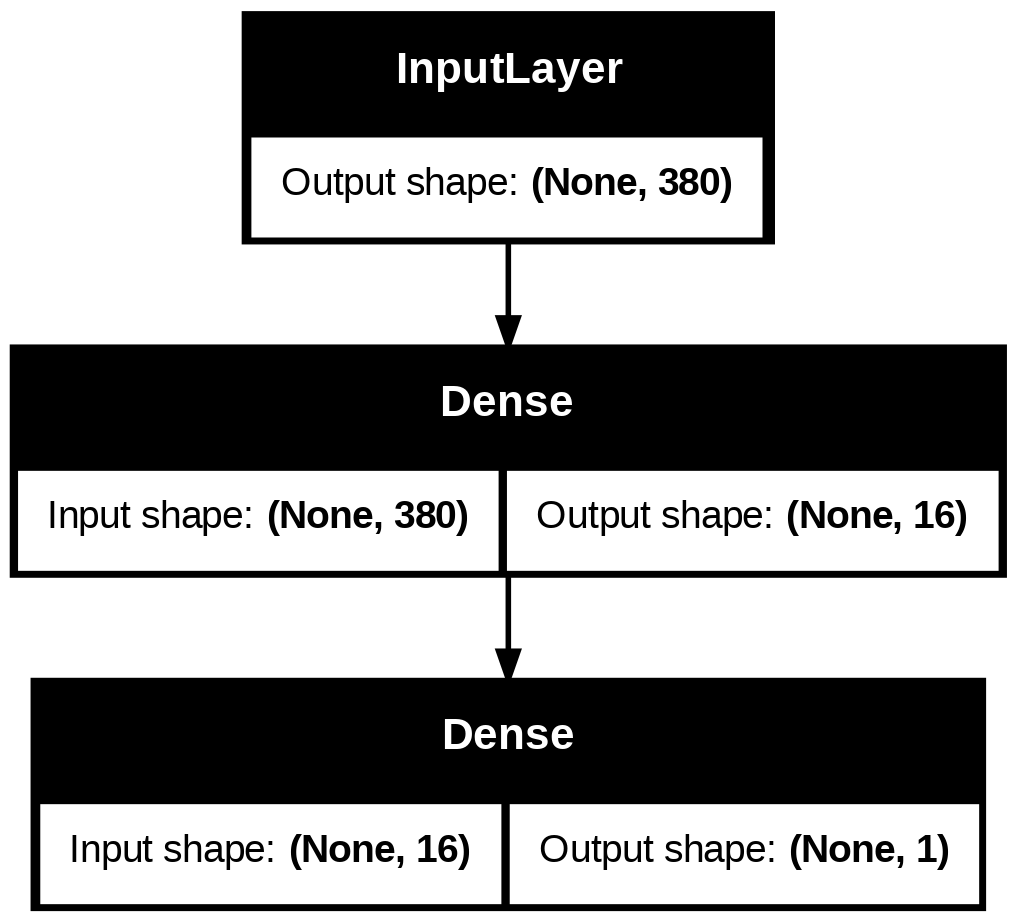

In [175]:
keras.utils.plot_model(nn_model, show_shapes=True)

In [176]:
nn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [177]:
history = nn_model.fit(X_train,
                       y_train,
                       epochs=30,
                       batch_size=32,
                       validation_split=0.2)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5717 - loss: 0.6814 - val_accuracy: 0.7476 - val_loss: 0.6343
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7644 - loss: 0.6390 - val_accuracy: 0.7714 - val_loss: 0.5901
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7356 - loss: 0.6109 - val_accuracy: 0.7667 - val_loss: 0.5589
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7672 - loss: 0.5727 - val_accuracy: 0.7714 - val_loss: 0.5299
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7599 - loss: 0.5567 - val_accuracy: 0.7714 - val_loss: 0.5122
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7946 - loss: 0.5107 - val_accuracy: 0.7762 - val_loss: 0.4992
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8056 - loss: 0.4898 - val_accuracy: 0.7762 - val_loss: 0.4850
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8005 - loss: 0.4875 - val_accuracy: 0.7714 - val_loss

In [178]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

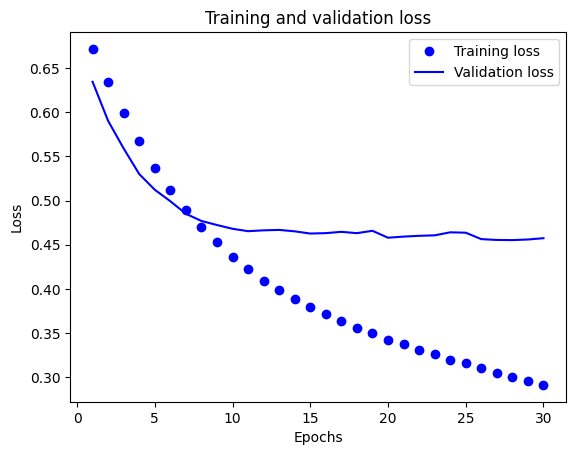

In [179]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

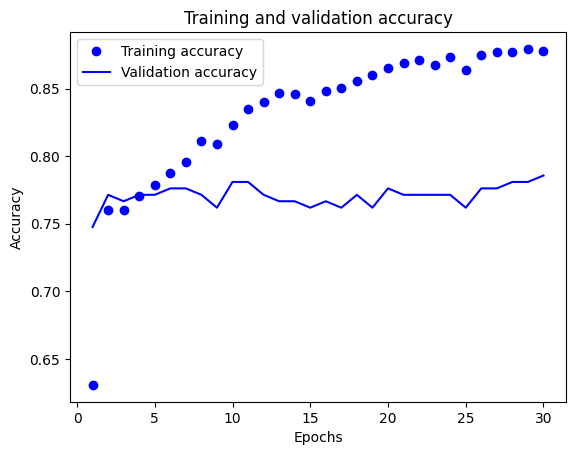

In [181]:
acc_values = history_dict["accuracy"]
val_acc_values = history_dict["val_accuracy"]
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, "bo", label="Training accuracy")
plt.plot(epochs, val_acc_values, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()